In [1]:
# !wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2024-07-08 17:44:24--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0.001s  

2024-07-08 17:44:25 (1.63 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [4]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


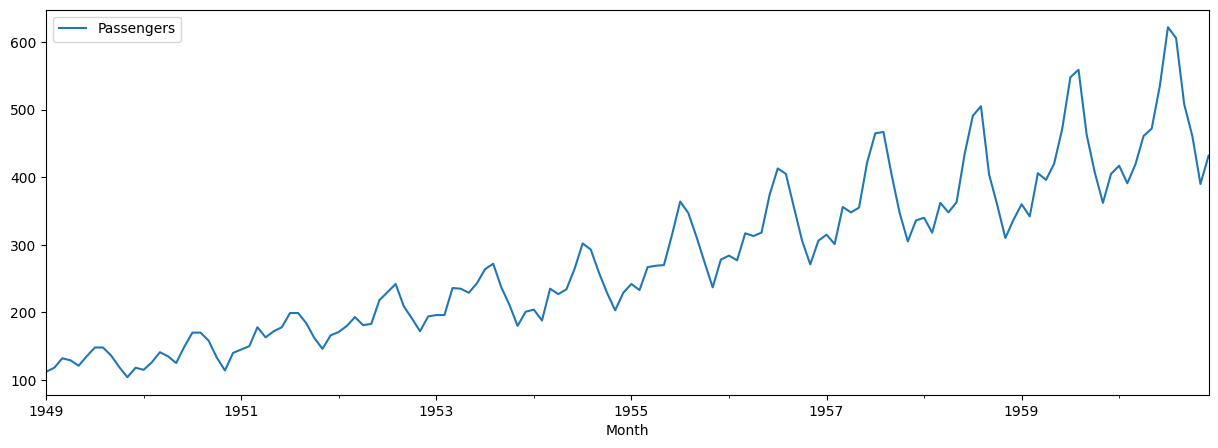

In [5]:
df.plot(figsize=(15, 5));

In [6]:
df['1stdiff'] = df['Passengers'].diff()

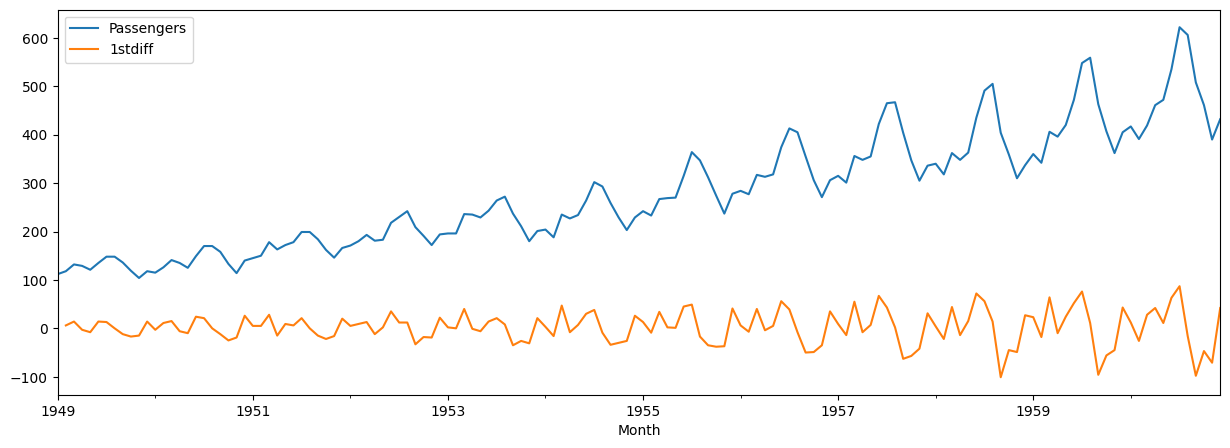

In [7]:
df.plot(figsize=(15, 5));

In [8]:
df['LogPassengers'] = np.log(df['Passengers'])

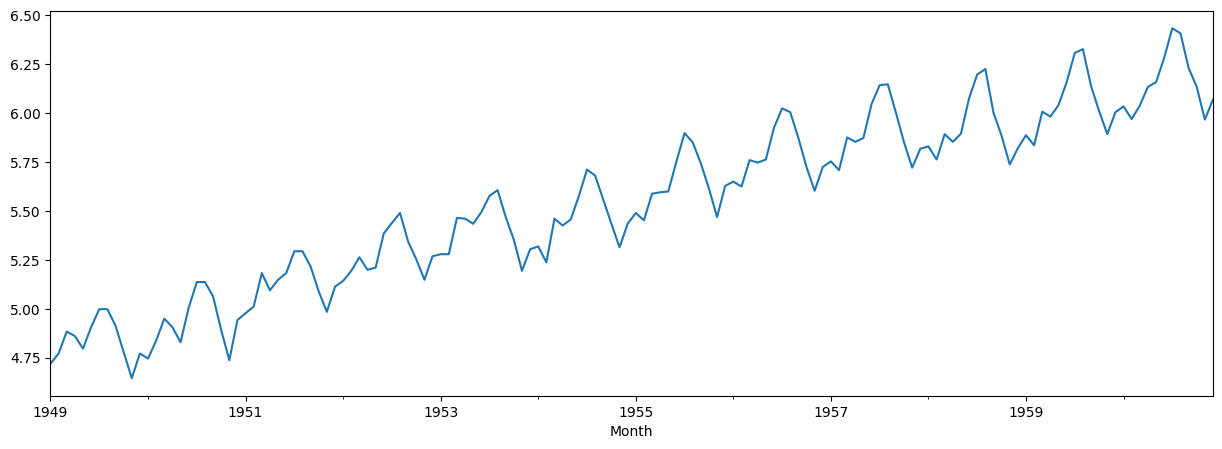

In [9]:
df['LogPassengers'].plot(figsize=(15, 5))

In [10]:
df['LogPassengers_diff'] = df['LogPassengers'].diff()

<Axes: xlabel='Month'>

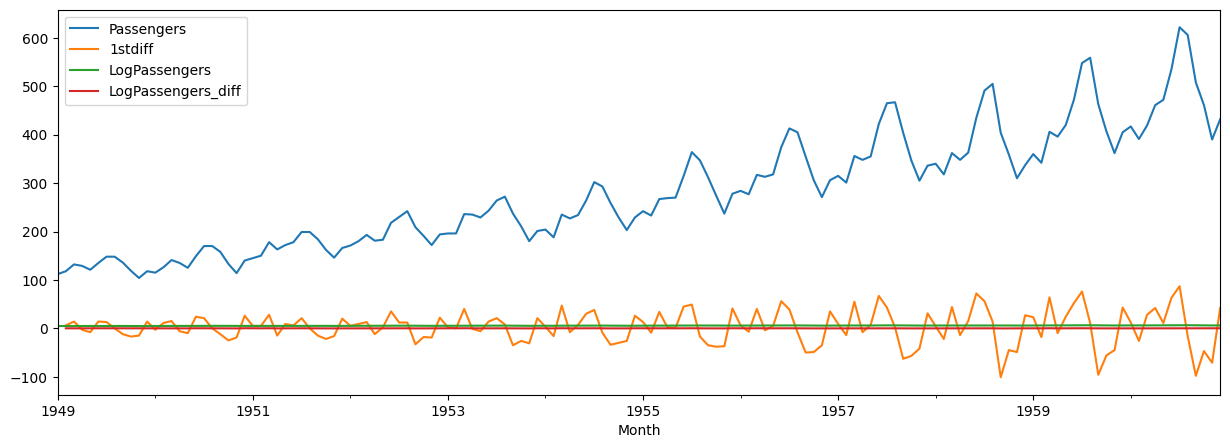

In [12]:
df.plot(figsize=(15, 5))

<Axes: xlabel='Month'>

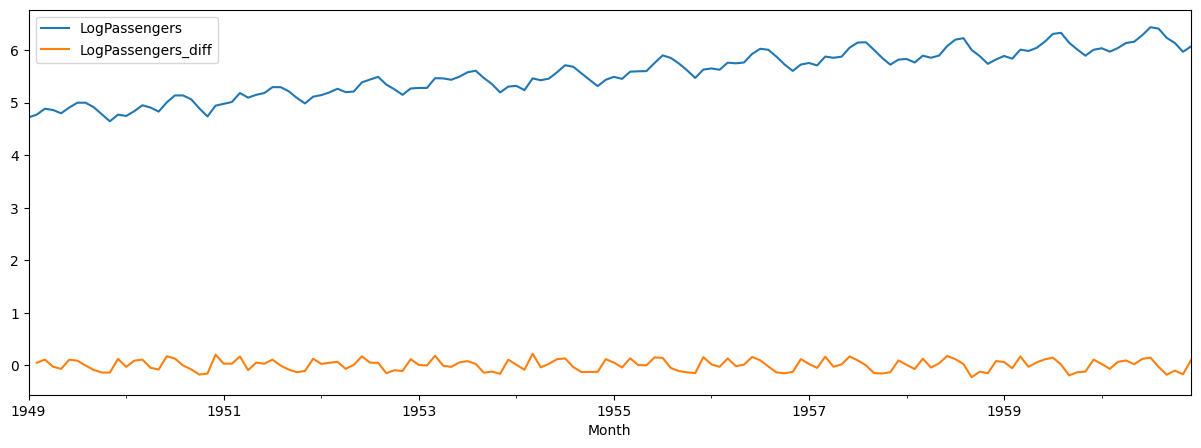

In [13]:
df[["LogPassengers","LogPassengers_diff"]].plot(figsize=(15, 5))

In [14]:
from statsmodels.tsa.arima.model import ARIMA

In [16]:
df.index.freq = 'MS' # define freq to month

Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [17]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [18]:
arima = ARIMA(train['Passengers'], order=(1,0,0))

In [19]:
arima_result = arima.fit()

In [20]:
df.loc[train_idx, 'AR(1)'] = arima_result.predict(
    start=train.index[0], end=train.index[-1])

<Axes: xlabel='Month'>

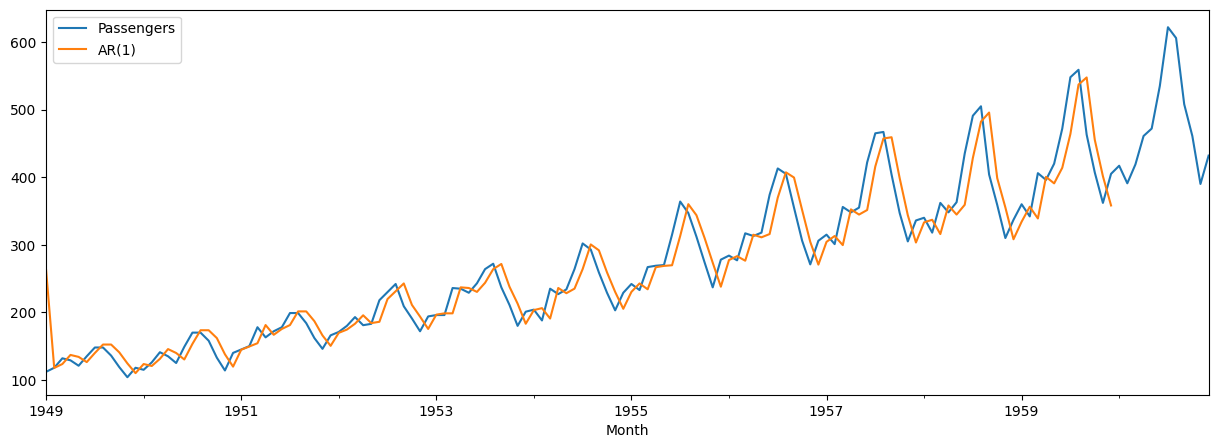

In [21]:
df[['Passengers', 'AR(1)']].plot(figsize=(15, 5))

In [22]:
prediction_result = arima_result.get_forecast(Ntest)
forecast = prediction_result.predicted_mean
df.loc[test_idx, 'AR(1)'] = forecast

<Axes: xlabel='Month'>

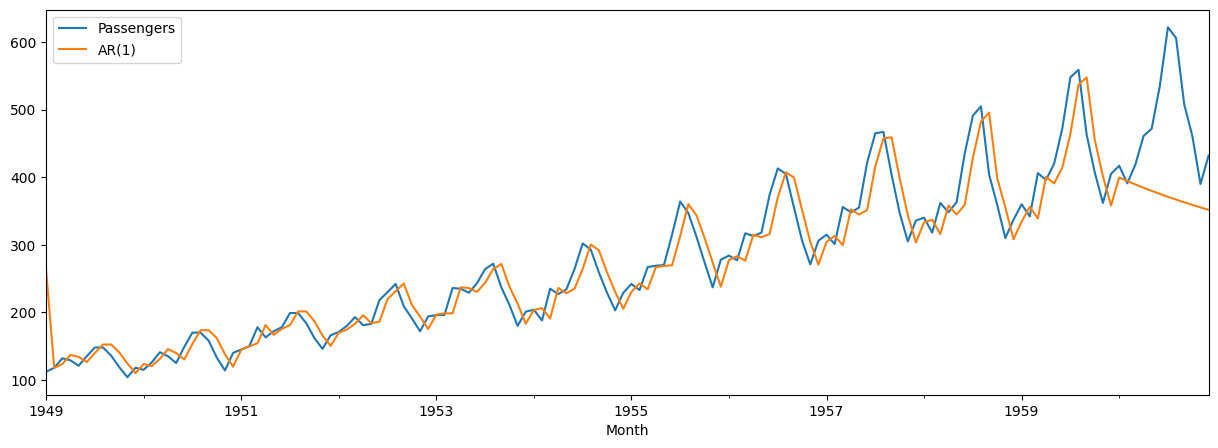

In [23]:
df[['Passengers', 'AR(1)']].plot(figsize=(15, 5))

In [24]:
# Explore prediction result further
type(prediction_result)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

In [25]:
# Confidence interval
prediction_result.conf_int()

,lower Passengers,upper Passengers
1960-01-01,338.658210,460.451500
1960-02-01,309.826171,478.809354
1960-03-01,287.732168,490.829379
1960-04-01,269.338256,499.534230
1960-05-01,253.432284,506.121347
1960-06-01,239.373402,511.217437
1960-07-01,226.768868,515.201638
1960-08-01,215.354570,518.324977
1960-09-01,204.941150,520.764224
1960-10-01,195.386337,522.649550


In [26]:
def plot_fit_and_forecast(result):
  fig, ax = plt.subplots(figsize=(15, 5))
  ax.plot(df['Passengers'], label='data')

  # plot the curve fitted on train set
  train_pred = result.fittedvalues
  ax.plot(train.index, train_pred, color='green', label='fitted')

  # forecast the test set
  prediction_result = result.get_forecast(Ntest)
  conf_int = prediction_result.conf_int()
  lower, upper = conf_int['lower Passengers'], conf_int['upper Passengers']
  forecast = prediction_result.predicted_mean
  ax.plot(test.index, forecast, label='forecast')
  ax.fill_between(test.index, \
                  lower, upper, \
                  color='red', alpha=0.3)
  ax.legend()

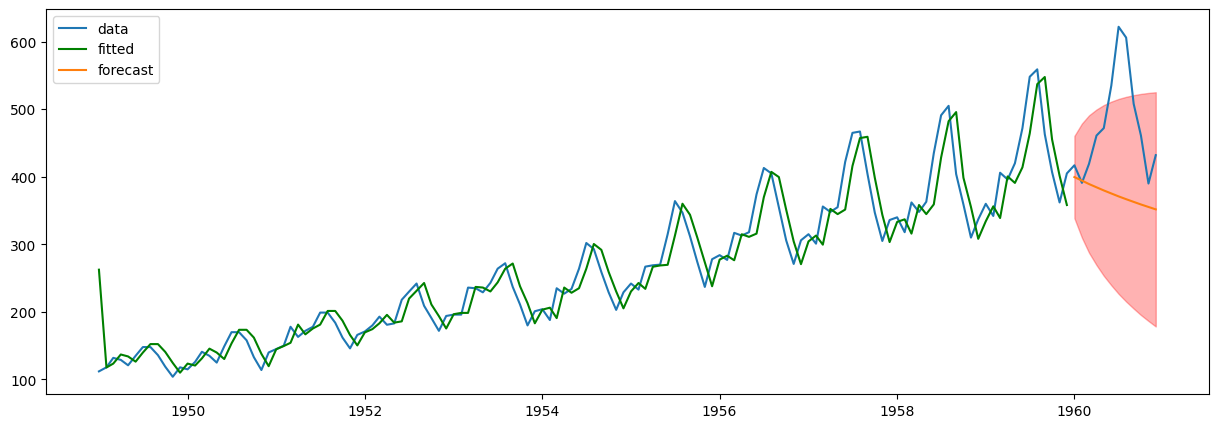

In [27]:
plot_fit_and_forecast(arima_result)

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


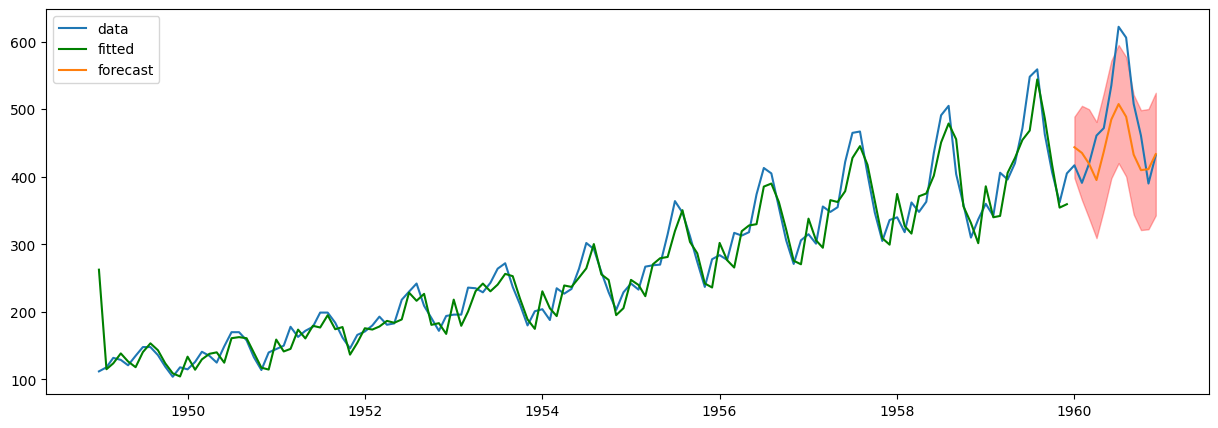

In [28]:
arima = ARIMA(train['Passengers'], order=(10,0,0)) # AR(10)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


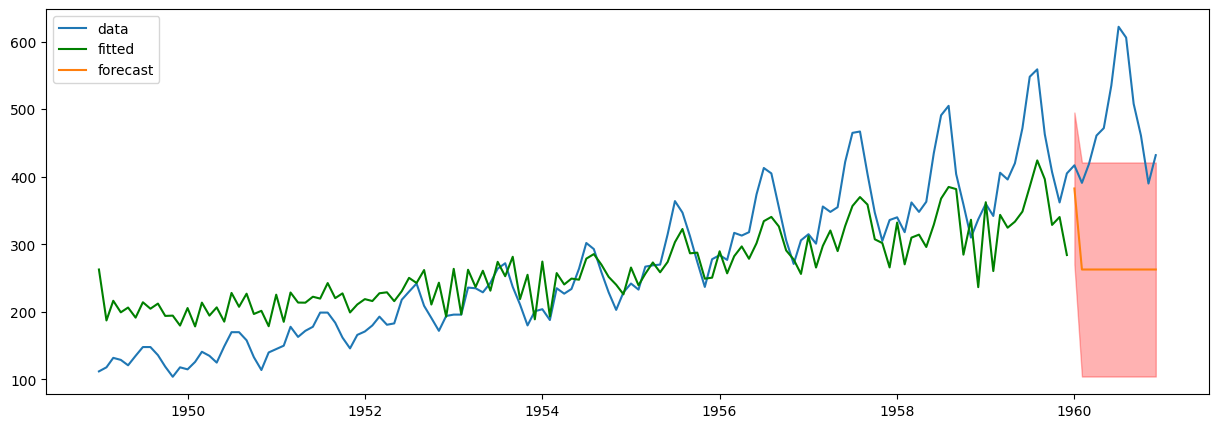

In [29]:
arima = ARIMA(train['Passengers'], order=(0,0,1)) # MA(1)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

In [30]:
df['Log1stDiff'] = df['LogPassengers'].diff()

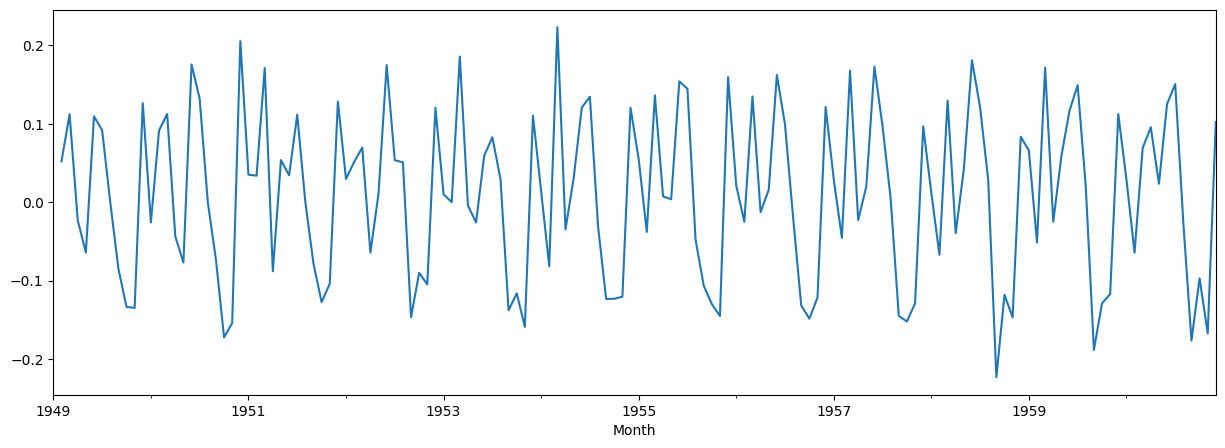

In [31]:
df['Log1stDiff'].plot(figsize=(15, 5));

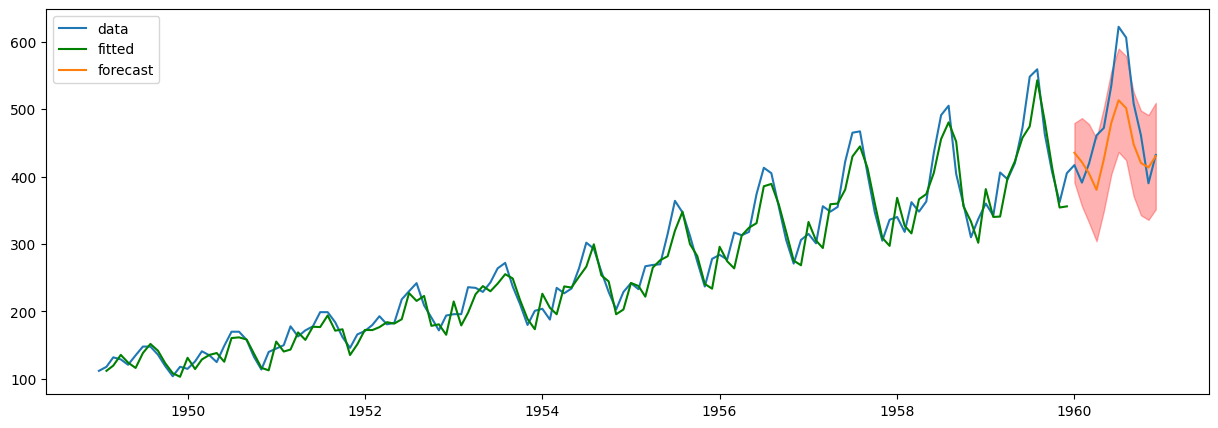

In [32]:
arima = ARIMA(train['Passengers'], order=(8,1,1))
arima_result_811 = arima.fit()

def plot_fit_and_forecast_int(result, d, col='Passengers'):
  fig, ax = plt.subplots(figsize=(15, 5))
  ax.plot(df[col], label='data')

  # plot the curve fitted on train set
  train_pred = result.predict(start=train.index[d], end=train.index[-1])

  ax.plot(train.index[d:], train_pred, color='green', label='fitted')

  # forecast the test set
  prediction_result = result.get_forecast(Ntest)
  conf_int = prediction_result.conf_int()
  lower, upper = conf_int[f'lower {col}'], conf_int[f'upper {col}']
  forecast = prediction_result.predicted_mean
  ax.plot(test.index, forecast, label='forecast')
  ax.fill_between(test.index, \
                  lower, upper, \
                  color='red', alpha=0.3)
  ax.legend()

plot_fit_and_forecast_int(arima_result_811, 1)

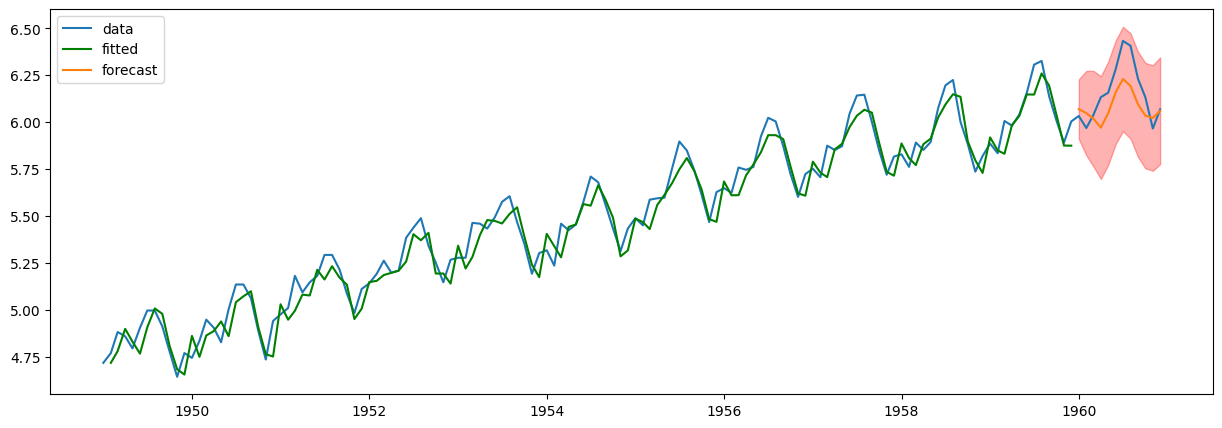

In [33]:
arima = ARIMA(train['LogPassengers'], order=(8,1,1))
arima_result_log811 = arima.fit()
plot_fit_and_forecast_int(arima_result_log811, 1, col='LogPassengers')

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


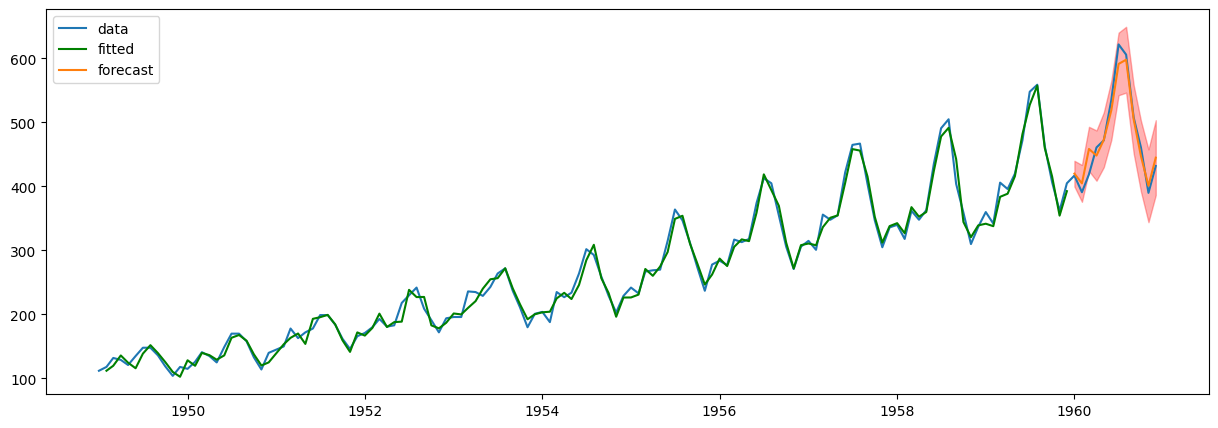

In [34]:
arima = ARIMA(train['Passengers'], order=(12,1,0))
arima_result_1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_1210, 1, col='Passengers')

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


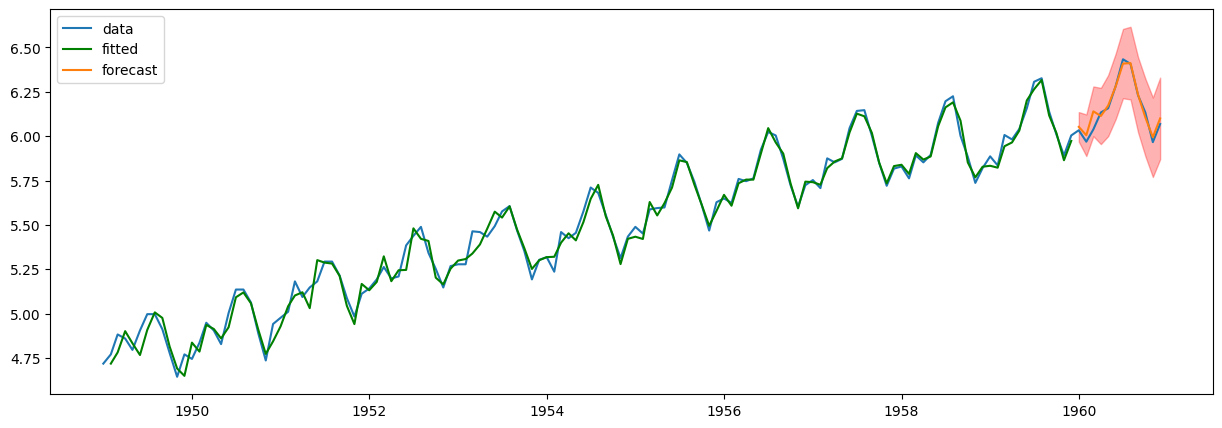

In [35]:
arima = ARIMA(train['LogPassengers'], order=(12,1,0))
arima_result_log1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_log1210, 1, col='LogPassengers')

In [36]:
def rmse(result, is_logged):
  forecast = result.forecast(Ntest)
  if is_logged:
    forecast = np.exp(forecast)
  
  t = test['Passengers']
  y = forecast
  return np.sqrt(np.mean((t - y)**2))

In [37]:
print("ARIMA(8,1,1):", rmse(arima_result_811, False))
print("ARIMA(8,1,1) logged:", rmse(arima_result_log811, True))
print("ARIMA(12,1,0):", rmse(arima_result_1210, False))
print("ARIMA(12,1,0) logged:", rmse(arima_result_log1210, True))

ARIMA(8,1,1): 59.064588122773486
ARIMA(8,1,1) logged: 61.60018486922116
ARIMA(12,1,0): 17.492873680587266
ARIMA(12,1,0) logged: 16.122420309299365
